# Cars Classification Model Using LeNet 5 Model 

##### Importing Python Libraries

In [118]:
import os
import random
import skimage.data
import skimage.transform
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import rank
import tensorflow as tf
from sklearn.utils import shuffle
import cv2
import skimage.morphology as morp
%matplotlib inline

######  Load Data From Directories

In [119]:
def load_data(data_dir):
    directories = [d for d in os.listdir(data_dir)
                  if os.path.isdir(os.path.join(data_dir,d))]
    labels = []
    images = []
    for d in directories:
        print("Dir",end=",")
        label_dir = os.path.join(data_dir,d)
        file_names = [os.path.join(label_dir,f) for f in os.listdir(label_dir) if f.endswith(".jpg")]
        
        for f in file_names:
            
            images.append(cv2.imread(f))
            labels.append(d)
    return images,labels
ROOT_PATH = "DATASET"
train_data_dir = os.path.join(ROOT_PATH, "TRAINING")
test_data_dir = os.path.join(ROOT_PATH, "TEST")

images,labels = load_data(train_data_dir)

Dir,Dir,Dir,Dir,

In [120]:
print("Unique Labels",len(set(labels)), "\nTotal Images", len(images))

Unique Labels 4 
Total Images 359


###### Display Random Images With Labels Function

In [121]:
def display_images_and_labels(images,labels):
    """Display the first images of each label."""
    unique_labels = set(labels)
    plt.figure(figsize=(15,15))
    i = 1
    for label in unique_labels:
        image = images[labels.index(label)]
        plt.subplot(8,8,i)
        plt.axis('off')
        plt.title('Label' + str(label) + '(' + str(labels.count(label)) + ')')
        i+=1
        _ = plt.imshow(image,cmap='gray')
    plt.show()
    

###### Converting Images To Gray Scale

In [122]:
def imagesToGrayScale(images):
    return [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in images]

In [123]:
imagesG = imagesToGrayScale(images)
# display_images_and_labels(imagesG, labels)

###### Resizing Images To A Fixed Scale

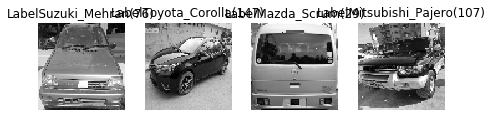

In [124]:
images32 = [skimage.transform.resize(image, (70,70), mode='constant') for image in imagesG]
display_images_and_labels(images32, labels)

######  Local Histogram Equalization

In [125]:
def local_histo_equalize(image):
    """
    Apply local histogram equalization to grayscale images.
        Parameters:
            image: A grayscale image.
    """
    kernel = morp.disk(30)
    img_local = rank.equalize(image, selem=kernel)
    return img_local

###### Image Normalization

In [126]:
def image_normalize(image):
    """
    Normalize images to [0, 1] scale.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    image = np.divide(image, 255)
    return image

In [127]:
equalized_images = list(map(local_histo_equalize, images32))

In [128]:
normalized_images = []
for i, img in enumerate(equalized_images):
    normalized_images.append(image_normalize(img))
normalized_images = np.array(normalized_images)[..., None]
# display_images_and_labels(normalized_images, labels)

###### LeNet 5 Model

In [129]:
from tensorflow.contrib.layers import flatten
import tensorflow as tf

def LeNet(x):    
    mu = 0
    sigma = 0.1

    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    conv3_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 400), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(400))
    conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
    conv3 = tf.nn.relu(conv3)
    
    fc0   = flatten(conv3)

    fc1_W = tf.Variable(tf.truncated_normal(shape=(40000 , 7700), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(7700))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    fc1 = tf.nn.dropout(fc1, keep_prob)
    fc1    = tf.nn.relu(fc1)

    fc2_W  = tf.Variable(tf.truncated_normal(shape=(7700, 777), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(777))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    fc2 = tf.nn.dropout(fc2, keep_prob)
    fc2    = tf.nn.relu(fc2)

    fc3_W  = tf.Variable(tf.truncated_normal(shape=(777, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b

    return logits

In [130]:
n_classes = len(set(labels))
EPOCHS = 10 
BATCH_SIZE = 120
x = tf.placeholder(tf.float32, (None, 70, 70,1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y,  n_classes)
keep_prob = tf.placeholder(tf.float32)

rate = 0.0001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [131]:
setLabels = list(set(labels))
encLabels = []
for label in labels:
    encLabels.append(setLabels.index(label))
encLabels[:10]

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [132]:
# Load the test dataset.
test_images, test_labels = load_data(test_data_dir)
import cv2
imagesTG = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in test_images]
# Transform the images, just like we did with the training set.
test_images32 = [skimage.transform.resize(image, (70, 70), mode='constant')
                 for image in imagesTG]

equalized_images_test = list(map(local_histo_equalize, test_images32))
normalized_images_test = []
for i, img in enumerate(equalized_images_test):
    normalized_images_test.append(image_normalize(img))
normalized_images_test = np.array(normalized_images_test)[..., None]
# test_images32= [np.resize(image, (45, 45, 1)) for image in test_images32]
# Run predictions against the full test set.
# Run predictions against the full test set.

encTestLabels = []
for label in test_labels:
    encTestLabels.append(setLabels.index(label))

Dir,Dir,Dir,Dir,

###### Training And Saving the Model

In [133]:

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(images)
    
    print("Training...")
    print()
    validation_accuracy_figure = []
    train_accuracy_figure = []
    test_accuracy_figure = []
    for i in range(EPOCHS):
        X_train, y_train = shuffle(normalized_images, encLabels)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        
        
        train_accuracy = evaluate(X_train, y_train)
        train_accuracy_figure.append(train_accuracy)
        print("EPOCH {} ...".format(i+1))
        print("Train Accuracy = {:.3f}".format(train_accuracy))
        print()
        
        signs_classes = sess.run(tf.argmax(logits, 1), feed_dict={x: normalized_images_test, keep_prob: 1.0})

        right_cnt = 0
        for (correct, predicted) in zip(encTestLabels, signs_classes):
            print(correct,predicted)
            if correct == predicted:
                right_cnt += 1

        print("Test Accuracy: ", round(right_cnt / len(test_images32), 3))
        test_accuracy_figure.append(right_cnt / len(test_images32))
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Train Accuracy = 0.359

2 3
2 3
2 3
2 0
2 3
2 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 0
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
3 3
0 3
0 3
0 3
0 0
0 3
0 3
0 3
0 3
0 3
0 3
0 3
0 3
0 3
0 3
1 1
1 3
1 3
1 3
1 3
1 0
1 3
1 3
1 3
1 3
1 0
1 3
1 3
1 3
1 3
1 3
1 3
1 3
1 3
1 3
1 3
1 3
1 3
1 3
1 3
1 3
1 3
1 3
1 3
Test Accuracy:  0.351
EPOCH 2 ...
Train Accuracy = 0.468

2 1
2 1
2 2
2 0
2 0
2 0
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
3 1
0 0
0 2
0 1
0 1
0 1
0 1
0 0
0 1
0 1
0 1
0 1
0 1
0 1
0 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
Test Accuracy:  0.432
EPOCH 3 ...
Train Accuracy = 0.571

2 1
2 0
2 2
2 0
2 2
2 2
3 1
3 1
3 1
3 2
3 1
3 1
3 2
3 1
3 0
3 1
3 0
3 2
3 1
3 0
3 2
3 1
3 1
3 1
3 1
3 1
3 1
3 0
3 1
3 2
3 0
0 0
0 2
0 0
0 1
0 2
0 0
0 2
0 0
0 1
0 0
0 0
0 2
0 0
0 0
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 3
1 0
1 0
1 0
1 0
1 1
1 1
1 1
1 1

UnknownError: Failed to WriteFile: ./lenet.data-00000-of-00001.tempstate14819663084721637449 : There is not enough space on the disk.
; Unknown error
	 [[node save_6/SaveV2 (defined at <ipython-input-130-7e1ae6d1e83f>:19) ]]

Caused by op 'save_6/SaveV2', defined at:
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "C:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 528, in run_forever
    self._run_once()
  File "C:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 1764, in _run_once
    handle._run()
  File "C:\ProgramData\Anaconda3\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\ioloop.py", line 758, in _run_callback
    ret = callback()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 1233, in inner
    self.run()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 370, in dispatch_queue
    yield self.process_one()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 346, in wrapper
    runner = Runner(result, future, yielded)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 1080, in __init__
    self.run()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 326, in wrapper
    yielded = next(result)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-130-7e1ae6d1e83f>", line 19, in <module>
    saver = tf.train.Saver()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py", line 832, in __init__
    self.build()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py", line 844, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py", line 881, in _build
    build_save=build_save, build_restore=build_restore)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py", line 510, in _build_internal
    save_tensor = self._AddSaveOps(filename_tensor, saveables)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py", line 210, in _AddSaveOps
    save = self.save_op(filename_tensor, saveables)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py", line 124, in save_op
    tensors)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_io_ops.py", line 1806, in save_v2
    name=name)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3300, in create_op
    op_def=op_def)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

UnknownError (see above for traceback): Failed to WriteFile: ./lenet.data-00000-of-00001.tempstate14819663084721637449 : There is not enough space on the disk.
; Unknown error
	 [[node save_6/SaveV2 (defined at <ipython-input-130-7e1ae6d1e83f>:19) ]]


In [ ]:
# Load the test dataset.
test_images, test_labels = load_data(test_data_dir)
import cv2
imagesTG = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in test_images]
# Transform the images, just like we did with the training set.
test_images32 = [skimage.transform.resize(image, (70, 70), mode='constant')
                 for image in imagesTG]

equalized_images_test = list(map(local_histo_equalize, test_images32))
normalized_images_test = []
for i, img in enumerate(equalized_images_test):
    normalized_images_test.append(image_normalize(img))
normalized_images_test = np.array(normalized_images_test)[..., None]
# test_images32= [np.resize(image, (45, 45, 1)) for image in test_images32]
# Run predictions against the full test set.
# Run predictions against the full test set.

encTestLabels = []
for label in test_labels:
    encTestLabels.append(setLabels.index(label))
with tf.Session() as sess:
    saver.restore(sess, './lenet')
    signs_classes = sess.run(tf.argmax(logits, 1), feed_dict={x: normalized_images_test, keep_prob: 1.0})

right_cnt = 0
for (correct, predicted) in zip(encTestLabels, signs_classes):
    print(correct,predicted)
    if correct == predicted:
        right_cnt += 1

print("Accuracy: ", round(right_cnt / len(test_images32), 3))

In [ ]:
x = len(test_accuracy_figure)

In [ ]:
plt.plot(list(range(len(train_accuracy_figure))),train_accuracy_figure)
plt.plot(list(range(len(test_accuracy_figure))),test_accuracy_figure)
plt.show()

In [ ]:
train_accuracy_figure